
# Modeling House and Rent Prices Using Neighborhood Factors across the US
Anna Zhong, Austin Wu, Cody He, and Eliza Hale for <b>CS109</b>

<img src="website/images/sanfrancisco_houses3.jpg">

## Contents

<a href="#project_overview">1. Project Overview</a>

- <a href="#project_overview">Background and Motivation</a>
- <a href="#project_overview">Questions</a>
- <a href="#project_overview">Our Approach</a>

<a href="#data">2. Data</a>

- <a href="#data">2.1 House and Rental Price Data</a>
- <a href="#dem_data">2.2 Demographic Data</a>
- <a href="#biz_data">2.3 Business Data</a>
- <a href="#yelp_data">2.4 Yelp Data</a>

<a href="#exploration">3. Exploratory Analysis<a/>

- <a href="#exploration">3.1 Neighborhood Trends in Demographic and Business Type</a>
- <a href="#exploration_price">3.2 Price Trends</a>
- <a href="exploration_yelp">3.3 Yelp Business Trends

<a href="#modeling">4. Modeling</a>
- <a href="#modeling">4.1 Model Features</a>
- <a href="#model_train">4.2 Train Data</a>
- <a href="#baseline">4.3 Baseline Prediction</a>
- <a href="#regression">4.4 Regression (and other models)</a>

<a href="#conclusion">5. Conclusion</a>

<a id="project_overview"></a>
# 1. Project Overview

## Background and Motivation
As a group of four seniors who are all heading across the United States after graduation and entering the real world, a pressing issue on our minds has been finding our first apartment or house in our new city.  We all want to find a place to call home, while also making a sound financial decision. Where in the city should we live? Should we rent? Should we buy? 

We are also interested in learning more about our new homes and how the composition of the community and local economy affect the financial value of real estate in our areas. Our new cities will have neighborhoods with their own distinct character, from the posh, expensive district to the gritty, up and coming. We are interested in how the fabric of these communities in terms of demographics as well as business factors 

To look deeper into these questions, we decided to look at Price-to-Rent (PTR) ratios of different areas of the United States, which is the median existing home price divided by the average annual rent you would pay for a comparable home in the area. This is an informative metric for whether to buy or rent a property. If PtR ratios are very high in an area, then renting is likely a better deal. If PtR ratios are very low, then buying a home is probably the way to go.


## Questions

Initially we were interested in looking at changes in housing prices across the US from 2000 to 2010, and how differences in demographic and business features between regions might be able to predict the change in housing prices. First, we had to make a decision about the granularity of our data in terms of geographic divisions.  Did we want to look as neighborhoods within a specific city?  Or look at each city, county, or zipcode in the US? We chose to perform our analysis at the zipcode level in order to maximize the sample size for our regression and to eliminate the intra-region heterogeneity that exists with larger geographies. 


## Our Approach
We initially retrieved zipcode-level data for median house price per square foot across the united state from Zillow, a real estate database company. For our predictors, we aggregated data from a variety of sources. Initially, we used 2010 census data which detailed zipcode-level demographic data. As we iterated through various regression models, we sought to improve our models by adding new predictors to our regression. We aggregated jail data and prison indicator variables (i.e. whether or not there is a jail in a zipcode) from enigma.io, median income data, number of businesses, from Yelp.  We also. We also built a python script that would allow us to use features from Census data that only existed at the county level and mapped the values to the corresonding zipcodes within the county. We gathered our predictors and merged them with the housing price data by zipcode.

We first regressed census data along with jail/prison data on change in housing prices from 2000 to 2010. Our first model had very low explanatory power, so we sought more features. However, as we thought about the story we wanted to tell, we started thinking that examining other response variables might lend to more interesting and easily interpretable conclusions. We looked at a Zillow metric for home values that accounts for some biases that come with using their raw house price data. We also eventually looked at price-to-rent ratio (PTR).

With regards to gathering and organizing our data, some of our data, like the 2010 census data and the Zillow real estate data, we were able to download tables that we converted to pandas and cleaned by dropping the NANs in the years we wished to analyze and other miscellenaeous modifications. We stored our pandas dataframes by pickling them.
For Yelp we randomly sampled zipcodes, grabbed businesses in categories in active, arts, education, nightlife, pets, shopping, restaurants, and took the proportion of busineseses in each category. For all of our features, we considered if we needed to transform or normalize the data, and did so, if necessary. For some features, where a large fraction of the observed data was a single value, we made binary indicator variables.

Eventually, the final model progress was: forward variable selection using ordinary least squares regression, linear regression with lasso regularization, linear regression with ridge regularization, and finally, support vector machines. We also employed k-fold validation and cross-validations for hyperparameters wherever necessary. Ultimately, our best model employed ridge regularization. Below, we will walk you through our project in detail. Please reference the following iPython Notebooks for even greater detail in metholodgy: <b>Data Wrangling,</b> and <b>Yelp Models, Feature Selection and Modeling</b>.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

<a id="data"></a>
# 2. Data

<a id="data"></a>
## 2.1 House and Rental Price Data

All of the data for our house prices and rental prices came from Zillow at http://www.zillow.com/research/data/. We had originally wanted to model the delta between price data from two points in time (2000 vs 2010). This raised several concerns:

1. Is <b>delta</b> the best information to model?
2. Which years would be the most appropriate to do our analysis on given the data available to us for features of our model?

After some exploratory analysis (simple linear regressions using our demographic data, described below) on the <b>delta</b>, we quickly saw that it would be difficult to model the change in prices on static demographic data alone (we think that it would require time series analysis, and more importantly, several years of demographic data, which was impossible to gather in this short time frame because US census data categories vary by year).

This is what led us to temporarily switch to attempting to model the housing prices alone (rather than the change in housing prices). Additional research online, on the topic of predicting housing prices, suggested that we ought to look at the ratio of housing prices to rental prices, or price to rent ratio (PTR ratio). A ratio helps illuminate whether it would be prudent to buy a house or to rent: a high ratio suggests that housing prices far exceed renting prices, so renting would be a better option, whereas a low ratio suggests that housing prices are low, and buying would be a better option.

With this in mind, we looked for rental price data from Zillow. Since Zillow only contained rental data from 2011 onward, we were limited to this in scope. With this in mind, we decided to proceed modeling the 2015 PTR ratio with a 2011 PTR baseline, along with various features from demographic and business data as well we describe in the next few sections. For both the housing prices and rental prices we used the "median price per square foot" with regard to each Zip Code to keep the scales the same.

In [53]:
pd.read_pickle('data/housing_rental_ratio.pkl').head()

,RegionName,r_agg_2011,r_agg_2015_adj,r_pct_delta,h_agg_2011,h_agg_2015_adj,h_pct_delta,ratio_2011,ratio_2015,ratio_pct_delta
0,11368,1.868000,2.188278,1.171455,373.833333,431.274105,1.153653,200.124911,197.083754,0.984804
1,79936,0.744167,0.694379,0.933096,80.333333,75.060164,0.934359,107.950728,108.096860,1.001354
2,60629,1.197000,1.180207,0.985971,107.166667,113.430961,1.058454,89.529379,96.111037,1.073514
3,90650,1.524333,1.640026,1.075898,228.750000,292.549418,1.278905,150.065602,178.380911,1.188686
4,11226,1.014000,1.277783,1.260141,309.166667,416.876846,1.348389,304.898093,326.250103,1.070030


<a id="dem_data"></a>
## 2.2 Demographic Data

To find demographic data, we took data from the 2010 Census on zipcodes across the US. This data information on demographics such as sex, age, and race. It also gave us information on household  composition: the percentage of households that have single male and female residents, the percentage of households with single mothers, percentage of households that were family households or non-family households, the percentage of households that had children or seniors, etc. We also integrated jail and prison data to provide a more complete view of the demographic distribution of the zip code.

To see precisely how files were cleaned, please take a look at the <b>Data Wrangling</b> iPython Notebook.

In [45]:
prison = pd.read_pickle('data/prison_binary.pkl').drop('state', 1).rename(columns = {'zip': 'zipcode'})
jail = pd.read_pickle('data/jail_binary.pkl').rename(columns = {'zip': 'zipcode'})
demographics = pd.read_pickle('data/cleaned_demographic_features.pkl').drop(['GEO.id', 'GEO.display-label'], 1)
demographics = demographics.rename(columns = {'GEO.id2': 'zipcode'})

There are too many demographic variables to see them all here, so to see the full documentation on the variable name encoding, please take a look at the <b>Data Wrangling</b> iPython Notebook.

In [46]:
demographics.head()

,zipcode,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056
1,00601,18570,12.8,16.2,13.9,11.7,13.3,13.1,10.2,5.7,3.1,48.9,6.6,8.5,6.9,5.4,6.3,6.3,4.9,2.7,1.3,51.1,6.3,7.7,7,6.3,6.9,6.8,5.3,2.9,1.8,93.1,3.1,0.4,0,0,99.5,77.8,5.1,2.6,20.3,9.6,20.3,10.2,3.3,10.1,5.5,39.5,29,84.3,15.7,2.9,0.5,2.84,3.27,7744,2.87
2,00602,41520,11.5,15.2,13.5,12.9,14.6,14,10.1,5.7,2.3,49.1,5.9,7.7,6.7,6.4,7,6.8,4.9,2.6,1.1,50.9,5.6,7.5,6.8,6.5,7.6,7.2,5.2,3.1,1.3,86.7,5.3,0.3,0.1,0,99.4,77.6,5.1,2.1,17.4,8,20.5,10.5,3,10,4.9,37.6,25.9,83,17,2.6,1.3,2.76,3.20,18073,2.62
3,00603,54689,12.2,14.2,13,13,12.7,12.6,12,7,3.3,48.6,6.4,7.3,6.5,6.4,6,5.8,5.6,3.2,1.4,51.4,5.8,7,6.5,6.6,6.6,6.7,6.4,3.7,2.1,82.9,7.6,0.3,0.2,0,98.5,71.1,4.7,1.7,22,10.9,26.4,12.7,4.1,13.8,6.8,34,31.1,82.5,17.5,3.6,1.5,2.53,3.06,25653,2.51
4,00606,6615,12.8,15.1,14.7,12.1,13.1,13.4,10.5,5.5,2.9,49.4,6.6,7.5,7.1,6.1,6.5,6.3,5.2,2.6,1.4,50.6,6.2,7.5,7.6,6,6.6,7,5.4,2.9,1.5,88.9,4.7,0.4,0,0.1,99.4,74.6,6.2,2.7,18.4,8.1,22.8,12.7,4.5,10.1,4.7,37.5,28.4,83.6,16.4,1.7,0.8,2.75,3.24,2877,2.83
5,00610,29016,11.8,15.1,12.6,13.4,13.9,12.6,11.2,6.7,2.8,48.6,6.2,7.7,6.4,6.6,6.5,5.9,5.1,3.2,1.1,51.4,5.6,7.5,6.2,6.9,7.4,6.7,6.1,3.5,1.7,82,7.2,0.3,0.1,0,99.2,74.4,4.9,1.9,19.9,9.4,22.8,11,3.4,11.9,5.8,36.5,29.4,85.9,14.1,1.9,0.8,2.67,3.14,12618,2.66


In [39]:
prison.head()

,zipcode,prison
0,35034,1
1,36089,1
2,35023,1
3,36025,1
4,36017,1


In [41]:
jail.head()

,zipcode,jail
0,36067,1
1,36507,1
2,36016,1
3,35034,1
4,35121,1


<a id="biz_data"></a>
## 2.3 Business Data

We also retrieved some business data from each zipcode from the US Census. This included the number of businesses within the zipcode, the size and amount of the payroll, as well as the median income of residents of each zipcode. This data was current to 2010.

To see precisely how files were cleaned, please take a look at the <b>Data Wrangling</b> iPython Notebook.

In [47]:
bus_patterns = pd.read_pickle('data/business_patterns.pkl').drop('Geographic area name', 1)
bus_patterns = bus_patterns.rename(columns = {'Number of establishments':'n_establishments'})
income = pd.read_pickle('data/medianIncome.pkl')

In [48]:
bus_patterns.head()

,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,zipcode
1,448,9185,70693,314508,01001
2,570,15633,82069,351589,01002
3,16,168,1297,5761,01003
4,21,189,1710,7241,01004
5,96,926,5698,24382,01005


In [49]:
income.head()

,zipcode,median_income
0,00601,13318
1,00602,14947
2,00603,14437
3,00606,11155
4,00610,16367


<a id="yelp_data"></a>
## 2.4 Yelp Data

To explore our business data in more detail than just the number of businesses present, we decided to look at what types of businesses are present in zip code geographies. To do this, we scraped Yelp data using the Yelp API. See the <b>Data Wrangling</b> iPython Notebook to see the details on this method. There were 17 categories of businesses that we looked for using the API:

In [50]:
categories = [
    'active',
    'arts',
    'beautysvc',
    'education',
    'financialservices',
    'food',
    'health',
    'hotelstravel',
    'massmedia',
    'nightlife',
    'pets',
    'professional',
    'publicservicesgovt',
    'realestate',
    'religiousorgs',
    'restaurants',
    'shopping'
]

Since the number of businesses varied by zipcode, we regularized the data by keeping track of the <b>fraction</b> of businesses in each category, and used this fraction as a feature. For example, if <b>02138</b> had 1,304 restaurants out of a total of 10,000 businesses, then the fraction in the column "restaurants" would be 0.1304. See the <b>Data Wrangling</b> iPython Notebook for the complete metholodogy. The cleaned dataframe of features is:

In [52]:
pd.read_pickle('data/yelpexport.pkl').head()

,active,arts,auto,beautysvc,education,financialservices,food,health,hotelstravel,massmedia,nightlife,pets,professional,publicservicesgovt,realestate,religiousorgs,restaurants,shopping,zipcode
0,0.044293,0.018750,0.101630,0.089946,0.015761,0.015489,0.107337,0.063587,0.070924,0.001087,0.029891,0.029891,0.044293,0.005707,0.020109,0.001359,0.172011,0.167935,11705
0,0.033516,0.012996,0.110123,0.088919,0.010260,0.015732,0.084131,0.093707,0.049932,0.000000,0.026676,0.020520,0.022572,0.004788,0.044460,0.008208,0.202462,0.170999,37128
0,0.044632,0.027744,0.113390,0.028951,0.019300,0.006031,0.075995,0.048251,0.125452,0.000000,0.007238,0.049457,0.106152,0.002413,0.168878,0.001206,0.044632,0.130277,98260
0,0.037657,0.016736,0.146444,0.029289,0.008368,0.000000,0.054393,0.033473,0.184100,0.004184,0.008368,0.037657,0.100418,0.008368,0.083682,0.000000,0.108787,0.138075,21660
0,0.047544,0.051506,0.083994,0.045166,0.020602,0.004754,0.061014,0.108558,0.148177,0.001585,0.002377,0.040412,0.116482,0.003170,0.107765,0.002377,0.032488,0.122029,93924


<a id="exploration"></a>
# 3. Exploratory Data Analysis

<a id="exploration"></a>
## 3.1 Neighborhood Trends in Business and Demographics

Demographic data: do a heat map of single householder and others (minority races?) 

Business data: rank industries by number of zip codes with that industry as the most popular, map out business data as well?

<a id="exploration_price"></a>
## 3.2 House and Rent Price Trends

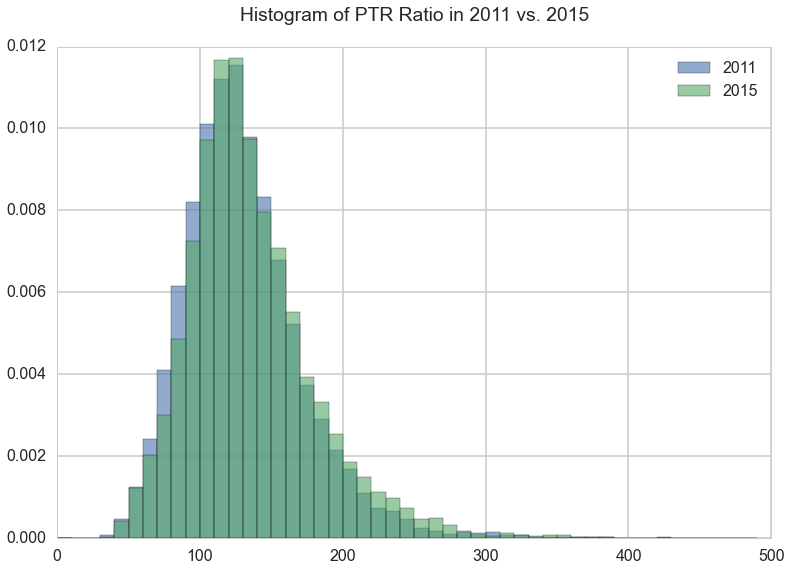

In [56]:
df = pd.read_pickle('data/housing_rental_ratio.pkl')
setbins = range(0,500,10)

plt.hist(df['ratio_2011'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2011');
plt.hist(df['ratio_2015'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2015');
plt.title('Histogram of PTR Ratio in 2011 vs. 2015\n');
plt.legend();

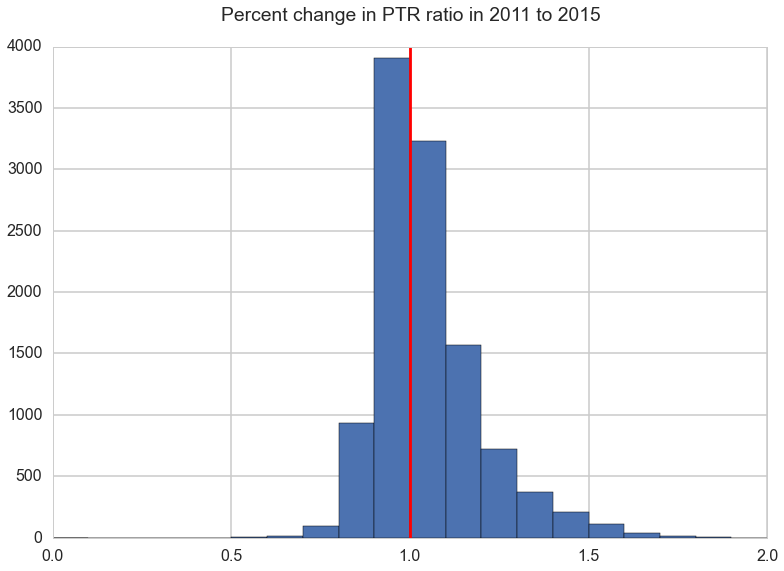

In [57]:
plt.hist(df['ratio_pct_delta'], bins=np.arange(0,2.1,0.1));
plt.axvline(x=1, color="red");
plt.title('Percent change in PTR ratio in 2011 to 2015\n');

From the first histogram above, it seems that PTR, on average, increases between 2011 and 2015. However, based on the second histogramabove, as well as the third choropleth map below, there is still a substantial fraction of zip codes where the PTR decreases.

<img src="images/PriceToRent.png">
We generated some choropleth maps using d3 to visualize what some of these metrics looked like across the country from 2011 to 2015. This is displayed on the county level, with data lacking in the white areas. With regards to price-to-rent ratio, we saw that it seemed to be getting cheaper to rent than to buy a home (as indicated by higher price-to-rent ratios) in California in 2015 compared to 2011. 

<img src="images/Delta.png">
This visualization, which shows the percentage change in the price-to-rent ratio, confirms our hypothesis about renting in California. Along with California, Michigan and the south of Florida seem to be areas where it is becoming increasingly cheaper to rent than to buy a home.

<a id="exploration_yelp"></a>
## 3.3 Yelp Business Trends

The Yelp Business data offered a lot of heterogeneity amongst features and zipcodes, as we can see in this choropleth of the prevalence of restaurants in zipcodes across the country. Our data set for Yelp data is only about 900 zipcodes.

# INCOMPLETE

We did some preliminary data analysis on these Yelp features, but found them to be rather subpar in their predictive power. Using feature selection from linear regression, and then more advanced methods like Lasso, Ridge Regression, and SVM, we tried to fit these features on PTR, but without too much success. Furthermore, scraping this data from Yelp took a lot of time (17 API calls for each zip code), and with roughly 10,000 zip codes in our testing and training dataframes, combined, it was impracticable to continue using these features (sadly).

<a id="modeling"></a>
# 4. Modeling

<a id="modeling"></a>
## 4.1 Model Features

We decided to use forward selection to select features for our regressions, this is the function for forward feature selection.

We experimented with the threshold for improvement (see \*\*\* threshold \*\*\* below), but found that our model became significantly worse with a tighter threshold.  Therefore we decided to keep features if they improved the model at all - this still lead to the pruning of a little less than 1/3 of the features.

In [1]:
# with help from http://planspace.org/20150423-forward_selection_with_statsmodels/
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        # *** threshold ***
        if current_score < (best_new_score * 1):
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    
    model = smf.ols(formula, data).fit()
    return (model, formula)

Import 2015 PTR ratio which is our response, and save the 2011 PTR ratio to be used as a feature

In [11]:
%%capture
ratio_response = pd.read_pickle('data/housing_rental_ratio2.pkl').rename(columns = {'zip': 'zipcode'})
ratio_2015_response = ratio_response[['zipcode','ratio_2015']]

# create ratio_2011 feature to be predictor!
ratio_2011_feature = ratio_response[['zipcode','ratio_2011']]

ratio_2011_feature['zipcode'] = ratio_2011_feature['zipcode'].astype('str')
ratio_2015_response['zipcode'] = ratio_2015_response['zipcode'].astype('str')

Import features which have already been normalized and transformed if they were very right-skewed

In [12]:
train_set_t = pd.read_pickle('data/train_all_features_norm_and_transform.pkl')
test_set_t = pd.read_pickle('data/test_all_features_norm_and_transform.pkl')
# save training and testing indices for later use
itrain_t_df = pd.DataFrame(train_set_t.index).rename(columns={0: 'ind'})
itest_t_df = pd.DataFrame(test_set_t.index).rename(columns={0: 'ind'})

features_t = pd.concat([train_set_t, test_set_t])
# merge to add PTR ratio for 2011 as a feature
features_t = features_t.merge(ratio_2011_feature, how='inner', on='zipcode')

merge the feature df with the response df for splitting into training at test sets

In [13]:
merged_ratio_2015 = ratio_2015_response.merge(features_t, how='inner', on=['zipcode'])
merged_ratio_2015 = merged_ratio_2015.astype('float')
merged_ratio_2015 = merged_ratio_2015.rename(columns={'ratio_2015':'response'})

# split into training and test sets
ratio_2015_train = merged_ratio_2015.merge(itrain_t_df, how='inner', right_on='ind', left_index=True)
ratio_2015_test = merged_ratio_2015.merge(itest_t_df, how='inner', right_on='ind', left_index=True)
print '%s samples in training set \n%s samples in test set'%(ratio_2015_train.shape[0], ratio_2015_test.shape[0])

8240 samples in training set 
2066 samples in test set


function to calculate RMSE (root mean squared error).  We thought it would be good to compare our results using both r-squared and rmse, as r-squared increases with the number of

In [16]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

Use forward selection to select best features, and calculate rmse for basic OLS regression on these features

In [17]:
import time
import patsy
from statsmodels.api import add_constant
start_time = time.time()

# bestmodel_ratio_2015 = forward_selected(ratio_2015_train.drop(['zipcode','ind'],1), 'response')

formula = bestmodel_ratio_2015[1].replace('response ~ ','')
data = ratio_2015_test.drop(['zipcode','ind'],1).dropna()
response = data['response']
data = data.drop('response',1)

df = patsy.dmatrix(formula, data=data)
pred = bestmodel_ratio_2015[0].predict(df, transform=False)

ols_rmse = get_rmse(response, pred)

print '%s seconds to train model'%(time.time() - start_time)
print 'Response Variable: Ratio 2015'
print 'RMSE for OLS is ' + str(ols_rmse)

0.0615620613098 seconds to train model
Response Variable: Ratio 2015
RMSE for OLS is 13.6105601759


<a id="model_train"></a>
## 4.2 Train Data

<a id="baseline"></a>
## 4.3 Baseline Prediction

<a id="regression"></a>
## 4.4 Regression 
Include graphs for evaluation (and all the other models we used)

<a id="conclusion"></a>
# 5. Conclusion

What were our findings?
Evaluate each model and talk about next steps.